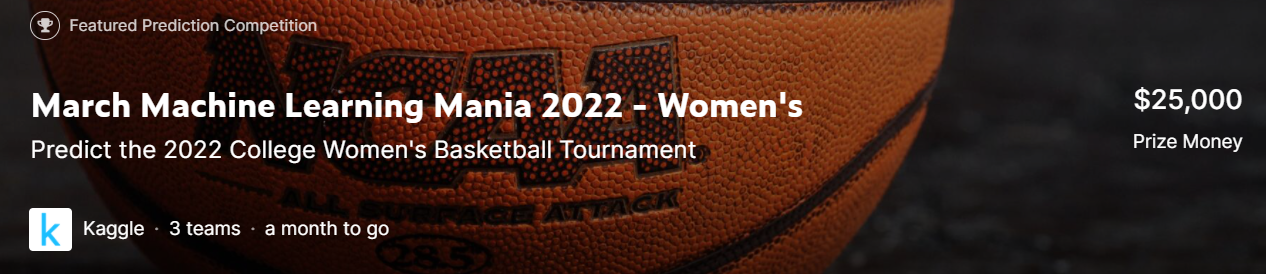

## This is a future prediction type competition.
## So you create a model using past data in stage 1, and stage 2 is the real thing.
## It seems to be held every year, and one of the features of this competition is that there are many CSV files.
## First, let's read the data.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Import</span>

In [ ]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc
import seaborn as sns
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import json
import plotly.express as ex

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Section 1 - The Basics</span>

In [ ]:
WTeams = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WTeams.csv')
WTeams

TeamID - a 4 digit id number, from 3000-3999, uniquely identifying each NCAA® women's team. A school's TeamID does not change from one year to the next, so for instance the Duke women's TeamID is 3181 for all seasons. To avoid possible confusion between the men's data and the women's data, all of the men's team ID's range from 1000-1999, whereas all of the women's team ID's range from 3000-3999.<br>
TeamName - a compact spelling of the team's college name, 16 characters or fewer. There are no commas or double-quotes in the team names, but you will see some characters that are not letters or spaces, e.g., Texas A&M, St Mary's CA, TAM C. Christi, and Bethune-Cookman.

In [ ]:
WSeasons = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WSeasons.csv')
WSeasons

In [ ]:
WSeasons.RegionW.unique()

In [ ]:
WSeasons.RegionX.unique()

In [ ]:
WSeasons.RegionY.unique()

In [ ]:
WSeasons.RegionZ.unique()

Season - indicates the year in which the tournament was played. Remember that the current season counts as 2022.<br>
DayZero - tells you the date corresponding to DayNum=0 during that season. All game dates have been aligned upon a common scale so that (each year) Selection Monday is on day 133. All game data includes the day number in order to make it easier to perform date calculations. If you need to know the exact date a game was played on, you can combine the game's "DayNum" with the season's "DayZero". For instance, since day zero during the 2011-2012 season was 10/31/2011, if we know that the earliest regular season games that year were played on DayNum=7, they were therefore played on 11/07/2011.<br>
RegionW, RegionX, Region Y, Region Z - by convention, the four regions in the final tournament are always named W, X, Y, and Z. Whichever region's name comes first alphabetically, that region will be Region W. And whichever Region plays against Region W in the national semifinals, that will be Region X. For the other two regions, whichever region's name comes first alphabetically, that region will be Region Y, and the other will be Region Z. This allows us to identify the regions and brackets in a standardized way in other files. For instance, during the 2012 tournament, the four regions were DesMoines, Fresno, Kingston, and Raleigh. Being the first alphabetically, DesMoines becomes W. Since the Fresno regional champion (Stanford) played against the DesMoines regional champion (Baylor) in the national semifinals, that makes Fresno be region X. For the other two (Kingston and Raleigh), since Kingston comes first alphabetically, that makes Kingston Y and therefore Raleigh is Z. So for that season, the W/X/Y/Z are DesMoines,Fresno,Kingston,Raleigh. And so for instance, Baylor, the #1 seed in the DesMoines region, is listed in the WNCAATourneySeeds file with a seed of W01, meaning they were the #1 seed in the W region (the DesMoines region). We will not know the final W/X/Y/Z designations until Selection Monday, because the national semifinal pairings in the Final Four will depend upon the overall ranks of the four #1 seeds.

In [ ]:
WNCAATourneySeeds = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WNCAATourneySeeds.csv')
WNCAATourneySeeds

In [ ]:
WNCAATourneySeeds.Seed.unique()

Season - the year that the tournament was played in<br>
Seed - this is a 3-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tell you the seed within the region. For example, the first record in the file is seed W01, which means we are looking at the #1 seed in the W region (which we can see from the "WSeasons.csv" file was the East region).<br>
TeamID - this identifies the id number of the team, as specified in the WTeams.csv file

In [ ]:
WRegularSeasonCompactResults =pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WRegularSeasonCompactResults.csv')
WRegularSeasonCompactResults

In [ ]:
WRegularSeasonCompactResults['score'] =WRegularSeasonCompactResults.WScore - WRegularSeasonCompactResults.LScore
data = WRegularSeasonCompactResults.groupby('WTeamID').agg(score=('score','mean'))

In [ ]:
sns.relplot(x=data.index, y='score', data=data, kind='line',ci='sd')
plt.gcf().set_size_inches(20, 10)
plt.show()

Season - this is the year of the associated entry in WSeasons.csv (the year in which the final tournament occurs). For example, during the 2016 season, there were regular season games played between November 2015 and March 2016, and all of those games will show up with a Season of 2016.<br>
DayNum - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date in the "WSeasons.csv" file. For example, the first game in the file was DayNum=18. Combined with the fact from the "WSeasons.csv" file that day zero was 10/27/1997 that year, this means the first game was played 18 days later, or 11/14/1997. There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key (combining Season and DayNum and WTeamID).<br>
WTeamID - this identifies the id number of the team that won the game, as listed in the "WTeams.csv" file. No matter whether the game was won by the home team or visiting team, or if it was a neutral-site game, the "WTeamID" always identifies the winning team.<br>
WScore - this identifies the number of points scored by the winning team.<br>
LTeamID - this identifies the id number of the team that lost the game.<br>
LScore - this identifies the number of points scored by the losing team. Thus you can be confident that WScore will be greater than LScore for all games listed.<br>
NumOT - this indicates the number of overtime periods in the game, an integer 0 or higher.
WLoc - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting team, this value will be "A". If it was played on a neutral court, then this value will be "N". Sometimes it is unclear whether the site should be considered neutral, since it is near one team's home court, or even on their court during a tournament, but for this determination we have simply used the Kenneth Massey data in its current state, where the "@" sign is either listed with the winning team, the losing team, or neither team. If you would like to investigate this factor more closely, we invite you to explore Data Section 3, which provides the city that each game was played in, irrespective of whether it was considered to be a neutral site.

In [ ]:
WNCAATourneyCompactResults = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WNCAATourneyCompactResults.csv')
WNCAATourneyCompactResults

### Stage 1 will be submitted in this format using historical data. Practice.

In [ ]:
WSampleSubmissionStage1 =pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WSampleSubmissionStage1.csv')
WSampleSubmissionStage1

ID - this is a 14-character string of the format SSSS_XXXX_YYYY, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team.<br>
Pred - this contains the predicted winning percentage for the first team identified in the ID field, the one represented above by XXXX.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Section 2 - Team Box Scores</span>

In [ ]:
WRegularSeasonDetailedResults = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WRegularSeasonDetailedResults.csv')
WRegularSeasonDetailedResults

In [ ]:
len(WRegularSeasonDetailedResults.WTeamID.unique())

WFGM - field goals made (by the winning team)<br>
WFGA - field goals attempted (by the winning team)<br>
WFGM3 - three pointers made (by the winning team)<br>
WFGA3 - three pointers attempted (by the winning team)<br>
WFTM - free throws made (by the winning team)<br>
WFTA - free throws attempted (by the winning team)<br>
WOR - offensive rebounds (pulled by the winning team)<br>
WDR - defensive rebounds (pulled by the winning team)<br>
WAst - assists (by the winning team)<br>
WTO - turnovers committed (by the winning team)<br>
WStl - steals (accomplished by the winning team)<br>
WBlk - blocks (accomplished by the winning team)<br>
WPF - personal fouls committed (by the winning team)

In [ ]:
point =['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']
WRegularSeasonDetailedResults.columns

In [ ]:
data = WRegularSeasonDetailedResults.groupby('WTeamID').mean()

In [ ]:
fig = plt.figure(figsize=(30,80))
x=1
for i in point: 
    fig.add_subplot(15,5, x)
    plt.title(i,fontsize=18)
    plt.plot(data.index,data[i])
    x+=1

In [ ]:
team = WRegularSeasonDetailedResults.WTeamID.unique()[:10]
fig = plt.figure(figsize=(30,80))
r=1
for i in team:
    fig.add_subplot(15,1, r)
    
    data = WRegularSeasonDetailedResults[WRegularSeasonDetailedResults.WTeamID==i]
    plt.title(i,fontsize=18)
    for x in point:    
        data2 = data.groupby('Season').agg(x=(x,'mean')).reset_index()
        plt.plot(data2.Season,data2.x)
    r+=1 


In [ ]:
WRegularSeasonDetailedResults['score'] =WRegularSeasonDetailedResults.WScore - WRegularSeasonDetailedResults.LScore
qx = sns.jointplot(x=WRegularSeasonDetailedResults.WTeamID.unique(), y=WRegularSeasonDetailedResults.groupby(['WTeamID'])['score'].mean().values, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})
qx.ax_joint.set_xlabel('WteamID')
qx.ax_joint.set_ylabel('score')
plt.show()

In [ ]:
WRegularSeasonDetailedResults

In [ ]:
team = WRegularSeasonDetailedResults.groupby(['WTeamID']).mean().reset_index()
team

In [ ]:
win = WRegularSeasonDetailedResults.WTeamID.value_counts()
teams = pd.DataFrame()
for i in win.index:
    data = team[team.WTeamID ==i]
    data['win'] = win[i]
    teams = pd.concat([teams,data])
teams

In [ ]:
sns.relplot(x='score',y='win',data=teams)
plt.gcf().set_size_inches(8, 8)

In [ ]:
fig = plt.figure(figsize=(30,80))
r=1 
for x in point:    
        fig.add_subplot(10,5, r)
        plt.title(x,fontsize=18)
        plt.scatter(x='win',y=x,data=teams)
        #p.set_title(x)
        r+=1 

In [ ]:
WNCAATourneyDetailedResults = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WNCAATourneyDetailedResults.csv')
WNCAATourneyDetailedResults

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Section 3 - Geography</span>

In [ ]:
Cities =pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/Cities.csv')
Cities

CityID - a four-digit ID number uniquely identifying a city.<br>
City - the text name of the city.<br>
State - the state abbreviation of the state that the city is in. In a few rare cases, the game location is not inside one of the 50 U.S. states and so other abbreviations are used, for instance Cancun, Mexico has a state abbreviation of MX.

In [ ]:
WGameCities = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WGameCities.csv')
WGameCities

Season, DayNum, WTeamID, LTeamID - these four columns are sufficient to uniquely identify each game. Additional data, such as the score of the game and other stats, can be found in the corresponding Compact Results file.<br>
CRType - this can be either Regular or NCAA. If it is Regular, you can find more about the game in the WRegularSeasonCompactResults.csv file. If it is NCAA, you can find more about the game in the WNCAATourneyCompactResults.csv file.<br>
CityID - the ID of the city where the game was played, as specified by the CityID column in the Cities.csv file.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Section 4 - Supplements</span>

In [ ]:
WTeamSpellings = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WTeamSpellings.csv',encoding = "shift-jis")
WTeamSpellings

TeamNameSpelling - this is the spelling of the team name. It is always expressed in all lowercase letters - e.g. "ball state" rather than "Ball State" - in order to emphasize that any comparisons should be case-insensitive when matching.<br>
TeamID - this identifies the TeamID for the team that has the alternative spelling (as described in WTeams.csv).

In [ ]:
WNCAATourneySlots = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WNCAATourneySlots.csv')
WNCAATourneySlots

Slot - this uniquely identifies one of the tournament games. It is a four-character string, where the first two characters tell you which round the game is (R1, R2, R3, R4, R5, or R6) and the second two characters tell you the expected seed of the favored team. Thus the first row is R1W1, identifying the Round 1 game played in the W bracket, where the favored team is the 1 seed. As a further example, the R2W1 slot indicates the Round 2 game that would have the 1 seed from the W bracket, assuming that all favored teams have won up to that point. The slot names are different for the final two rounds, where R5WX identifies the national semifinal game between the winners of regions W and X, and R5YZ identifies the national semifinal game between the winners of regions Y and Z, and R6CH identifies the championship game. The "slot" value is used in other columns in order to represent the advancement and pairings of winners of previous games.<br>
StrongSeed - this indicates the expected stronger-seeded team that plays in this game. For Round 1 games, a team seed is identified in this column (as listed in the "Seed" column in the WNCAATourneySeeds.csv file), whereas for subsequent games, a slot is identified in this column. In the first record of this file (slot R1W1), we see that seed W01 is the "StrongSeed". Whereas for games from Round 2 or later, rather than a team seed, we will see a "slot" referenced in this column. So in the 33rd record of this file (slot R2W1), it tells us that the winners of slots R1W1 and R1W8 will face each other in Round 2. Of course, in the last few games of the tournament - the national semifinals and finals - it's not really meaningful to talk about a "strong seed" or "weak seed", since you would have #1 seeds favored to face each other, but those games are nevertheless represented in the same format for the sake of consistency.<br>
WeakSeed - this indicates the expected weaker-seeded team that plays in this game, assuming all favored teams have won so far. For Round 1 games, a team seed is identified in this column (as listed in the "Seed" column in the WNCAATourneySeeds.csv file), whereas for subsequent games, a slot is identified in this column.

In [ ]:
Conferences =pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/Conferences.csv')
Conferences

ConfAbbrev - this is a short abbreviation for each conference; the abbreviation is used in some other files to indicate the parent conference of a team or of a conference tournament.<br>
Description - this is a longer text name for the conference.

In [ ]:
WTeamConferences = pd.read_csv('../input/womens-march-mania-2022/WDataFiles_Stage1/WTeamConferences.csv')
WTeamConferences

Season - this is the year of the associated entry in WSeasons.csv (the year in which the final tournament occurs)<br>
TeamID - this identifies the TeamID (as described in WTeams.csv).<br>
ConfAbbrev - this identifies the conference (as described in Conferences.csv).

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Sample LGBM</span>

### This is historical data, so I need to incorporate Leak to increase my score.

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
#!pip install optuna
import optuna 
import optuna.integration.lightgbm as lgbo

In [ ]:
y = WRegularSeasonDetailedResults.pop('score')

In [ ]:
_ = WRegularSeasonDetailedResults.pop('WLoc')

In [ ]:
reg = lgb.LGBMRegressor(n_estimators=150) 
reg.fit(WRegularSeasonDetailedResults, y)

In [ ]:
WSampleSubmissionStage1

In [ ]:
x=0
for row in WSampleSubmissionStage1.iterrows():
    YY = int(row[1]['ID'].split('_')[0])
    WW = int(row[1]['ID'].split('_')[1])
    LL = int(row[1]['ID'].split('_')[2])
    
    data =  WRegularSeasonDetailedResults[WRegularSeasonDetailedResults.Season == YY ]
    check1 = reg.predict(data[data.WTeamID==WW]).mean()
    check2 = reg.predict(data[data.WTeamID==LL]).mean()
    
    WSampleSubmissionStage1.loc[x,'Pred'] = np.clip((check1/check2) -0.5 ,0,1)
    x+=1

In [ ]:
WSampleSubmissionStage1.to_csv('submission.csv',index=False)

In [ ]:
WSampleSubmissionStage1.Pred.mean()